# PQ3 - Analyze/Plot AirBnB with POIs (in London)

In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import box
import numpy as np
import matplotlib.pyplot as plt


gdf = gpd.read_file('data/pois/accomodation+pois/consolidated_pois.geojson')
gdf = gdf.to_crs(epsg=4326)
# Number_of_reviews > 1
#gdf = gdf.loc[gdf['Number_of_reviews'] > 1]
gdf_england = gdf.loc[gdf['country']== 'united-kingdom']
gdf_boroughs = gpd.read_file('data/rq3/london_boroughs.geojson')
gdf_boroughs = gdf_boroughs.to_crs(epsg=4326)

# Prepare the data 
gdf_boroughs = gdf_boroughs.reset_index(drop=True)
gdf_boroughs = gdf_boroughs.rename(columns={'name': 'borough_name', 'index': 'borough_id'})
gdf_boroughs = gdf_boroughs.to_crs(epsg=4326)

# Get only the POIs in London
gdf_poi_london =gpd.sjoin(gdf_england, gdf_boroughs, how='inner', predicate='intersects')
gdf_poi_london.rename(columns={'index_right': 'borough_id'}, inplace=True)


# Get Airbnbs and transform to gdf
df_airbnb = pd.read_csv('data/airbnb_london/listings.csv')
gdf_airbnb = gpd.GeoDataFrame(df_airbnb, geometry=gpd.points_from_xy(df_airbnb.longitude, df_airbnb.latitude), crs="EPSG:4326")
airbnb_gdf_london = gpd.sjoin(gdf_airbnb, gdf_boroughs, how='inner', predicate='intersects')
airbnb_gdf_london.rename(columns={'index_right': 'borough_id'}, inplace=True)

# One-hot encoding for tag_value and prefix with tag_
poi_ohe_tags = pd.get_dummies(gdf_poi_london.tag_key, prefix='tag')
# Merge one-hot encoded tags to the original DataFrame nad rename with prefix tag_
gdf_poi_london = gdf_poi_london.merge(poi_ohe_tags, left_index=True, right_index=True)
# Get encoded tags columns for later use
encoded_tag_columns = [col for col in gdf_poi_london.columns if col.startswith('tag_')]

In [2]:
# Get only the transport POIs
transport_tags = ['transport-station', 'train-station', 'subway-entrance', 'bus-station']
gdf_transport_pois = gdf_poi_london[gdf_poi_london['tag_value'].isin(transport_tags)]
# Change the crs to EPSG:27700 (for distance calculation in meters)
gdf_transport_pois = gdf_transport_pois.to_crs(epsg=27700)
airbnb_gdf_london = airbnb_gdf_london.to_crs(epsg=27700)

# Calculate distance between each Airbnb and the closest transport POI
distances_airbnb_transport = []
for idx, airbnb in airbnb_gdf_london.iterrows():
    distances = gdf_transport_pois.geometry.distance(airbnb.geometry)
    distances_airbnb_transport.append(distances.min())

# Add the distances to the Airbnb GeoDataFrame
airbnb_gdf_london['distance_to_transport'] = distances_airbnb_transport
# Change the crs to EPSG:4326
airbnb_gdf_london = airbnb_gdf_london.to_crs(epsg=4326)

In [3]:
# Define grid resolution (e.g., 500 meters)
grid_size = 1000  # meters
crs = "EPSG:27700"  # British National Grid (to measure in meters)
gdf_boroughs = gdf_boroughs.to_crs(crs)

# Get bounds of London boroughs
minx, miny, maxx, maxy = gdf_boroughs.total_bounds

# Create grid cells
x_coords = np.arange(minx, maxx, grid_size)
y_coords = np.arange(miny, maxy, grid_size)

grid_cells = []
for x in x_coords:
    for y in y_coords:
        grid_cells.append(box(x, y, x + grid_size, y + grid_size))

# Create GeoDataFrame for the grid
grid = gpd.GeoDataFrame(geometry=grid_cells, crs=crs)
grid = gpd.clip(grid, gdf_boroughs)
grid = grid.to_crs("EPSG:4326")
gdf_boroughs = gdf_boroughs.to_crs("EPSG:4326")


# Spatial join to assign POIs to grid cells
poi_in_grid = gpd.sjoin(gdf_poi_london, grid, how='inner', predicate='intersects')
poi_in_grid = poi_in_grid.rename(columns={'index_right': 'index_borough'})

# Count POIs in each grid cell
grid['poi_density'] = poi_in_grid.groupby('index_borough').size()
grid['poi_density'] = grid['poi_density'].fillna(0)

# Get aggregated tag values for each grid cell
aggregated_poi_tags = poi_in_grid.groupby('index_borough')[encoded_tag_columns].sum()
aggregated_poi_tags = aggregated_poi_tags.reset_index()
# Merge the aggregated one-hot encoded tags with the grid
grid = grid.merge(aggregated_poi_tags,left_index=True ,right_index=True,how='left')
grid[encoded_tag_columns] = grid[encoded_tag_columns].fillna(0)

# Spatial join to assign Airbnb listings to grid cells
airbnb_in_grid = gpd.sjoin(airbnb_gdf_london, grid, how='inner', predicate='intersects')
poi_in_grid = poi_in_grid.rename(columns={'index_right': 'index_borough'})
# Calculate Airbnb metrics for each grid cell
grid['listing_count'] = airbnb_in_grid.groupby('index_right').size()
grid['average_reviews'] = airbnb_in_grid.groupby('index_right')['number_of_reviews_ltm'].mean()
grid['average_reviews'] = grid['average_reviews'].fillna(0)
grid['listing_count'] = grid['listing_count'].fillna(0)
# Calculate the average distance to transport POIs for each grid cell
grid['average_distance_to_transport'] = airbnb_in_grid.groupby('index_right')['distance_to_transport'].mean()

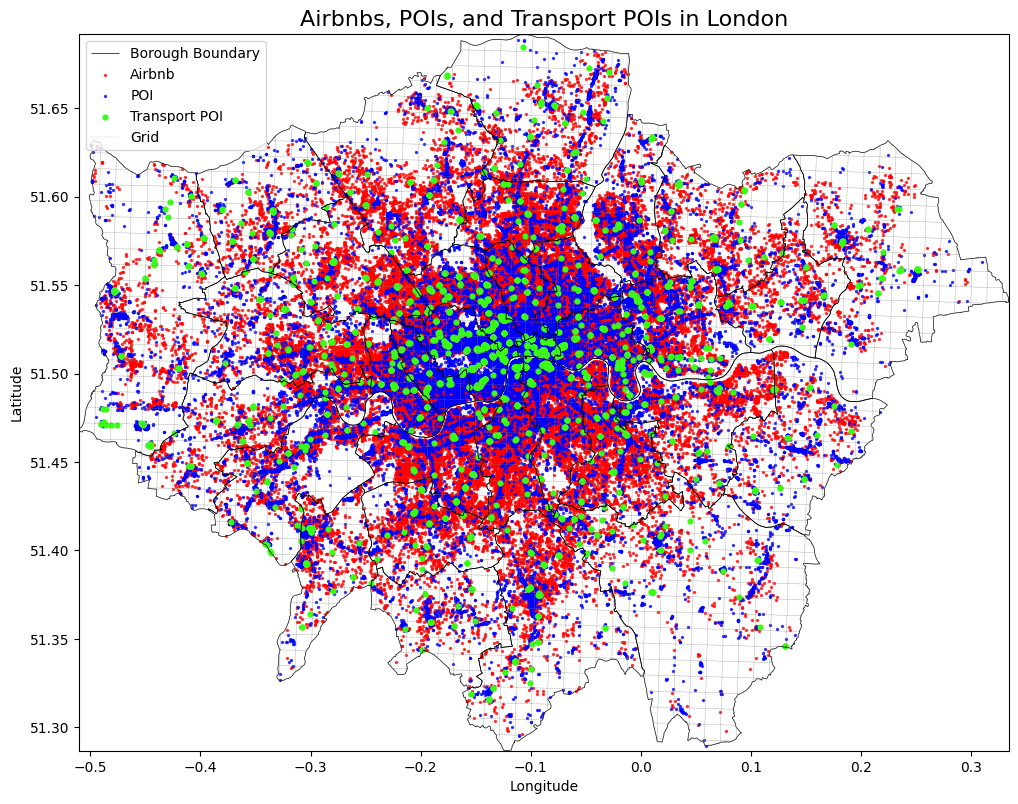

In [4]:
# Plot the data on a map
fig, ax = plt.subplots(figsize=(12, 12))

# Add data to the plot
gdf_boroughs.boundary.plot(ax=ax, color='black', linewidth=0.5, label='Borough Boundary')
airbnb_gdf_london.plot(ax=ax, color='red', markersize=2, alpha=0.7, label='Airbnb')
gdf_poi_london.plot(ax=ax, color='blue', markersize=2, alpha=0.7, label='POI')
gdf_transport_pois.to_crs(epsg=4326).plot(ax=ax,color='#39FF14',markersize=12,alpha=1.0, label='Transport POI')

# Add grid cells
grid.boundary.plot(ax=ax, color='gray', linewidth=0.3, linestyle='--', alpha=0.5, label='Grid')

# Add rest of the plot elements
plt.legend(loc='upper left')
ax.set_title('Airbnbs, POIs, and Transport POIs in London', fontsize=16)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Minimize unused space around the plot
ax.set_xlim(gdf_boroughs.total_bounds[[0, 2]])
ax.set_ylim(gdf_boroughs.total_bounds[[1, 3]])

plt.show()

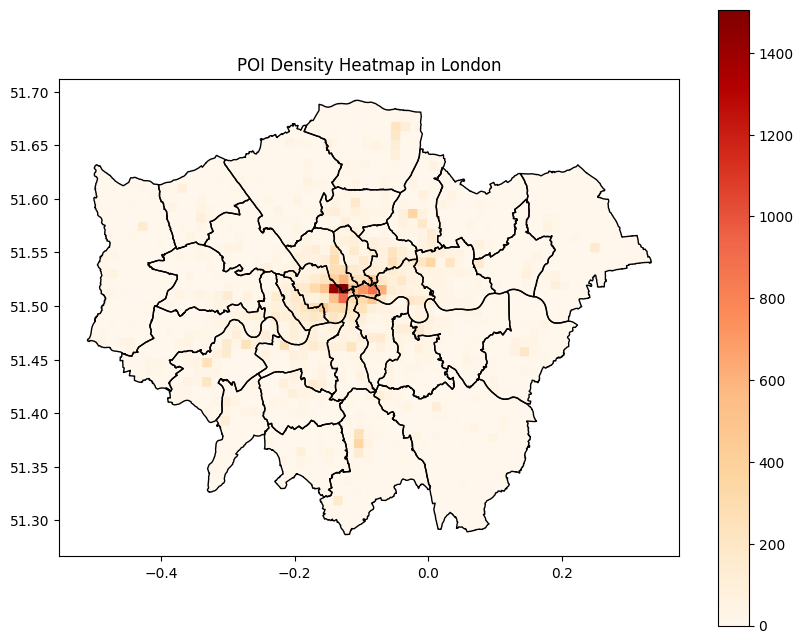

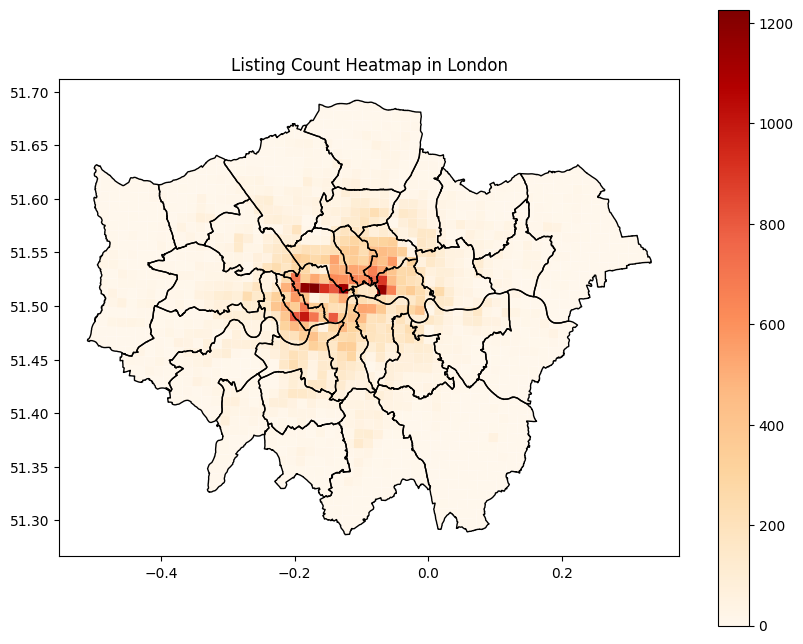

In [5]:
# POI Density Heatmap with Borough Boundaries
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
grid.plot(column='poi_density', cmap='OrRd', legend=True, ax=ax)
gdf_boroughs.boundary.plot(ax=ax, edgecolor='black', linewidth=1)  # Add borough boundaries
plt.title('POI Density Heatmap in London')
plt.show()

# Listing Count Heatmap with Borough Boundaries
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
grid.plot(column='listing_count', cmap='OrRd', legend=True, ax=ax)
gdf_boroughs.boundary.plot(ax=ax, edgecolor='black', linewidth=1)  # Add borough boundaries
plt.title('Listing Count Heatmap in London')
plt.show()

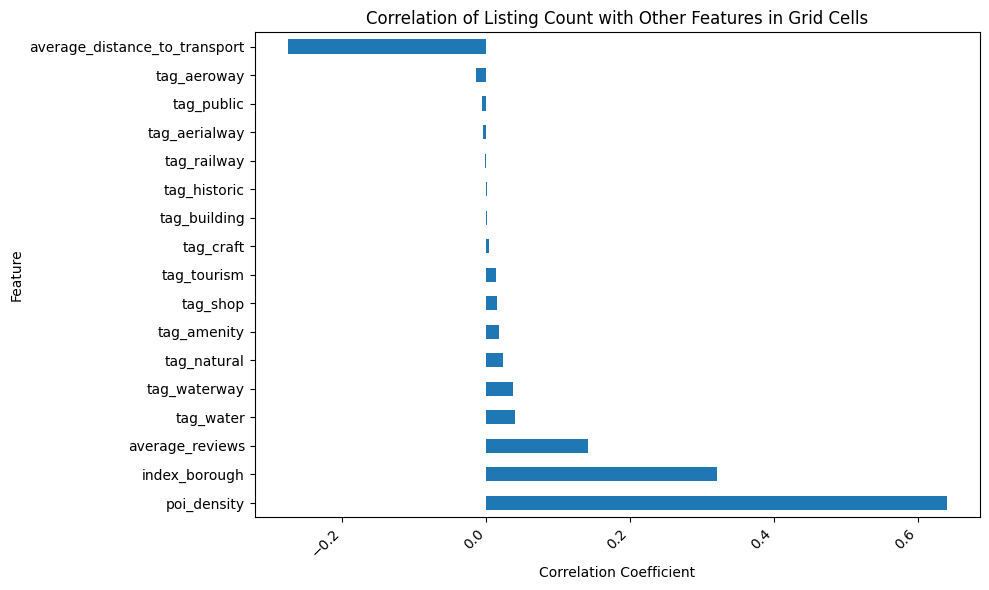

In [6]:
# Compute correlation with listing_count and plot
correlations = grid[grid.select_dtypes(include=['float64', 'int64']).columns].corr()['listing_count'].sort_values(ascending=False)

plt.figure(figsize=(10, 6))
correlations[1:].plot(kind='barh') 
plt.title('Correlation of Listing Count with Other Features in Grid Cells')
plt.ylabel('Feature')
plt.xlabel('Correlation Coefficient')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()